# REGO3 - Prédiction Émissions CO2 Bâtiments Seattle
## Notebook 01 : Exploration et Catégorisation des Variables

---

### Identité
* **Population cible** : Bâtiments non-résidentiels
* **Date création** : 12 Janvier 2026
* **Objectif** : Catégoriser les variables pour 3 modèles distincts

### Stratégie 3 Modèles
1. **Modèle 1 (Prédictif Pur)** : Variables autorisées uniquement
2. **Modèle 2 (Data Leakage Complet)** : + Consommations réelles
3. **Modèle 3 (Data Leakage Partiel)** : + ENERGY STAR Score

### Livrables
1. Dataset filtré au premier degré (non-résidentiel)
2. Catégorisation des 46 variables
3. Statistiques descriptives de la cible
4. Analyse des valeurs manquantes
5. Corrélations variables autorisées

---

# Sections de ce notebook

0. [Imports et Configuration](#section-0)
1. [Chargement et Filtrage](#section-1)
2. [Catégorisation Variables (3 Modèles)](#section-2)
3. [Analyse Variable Cible](#section-3)
4. [Valeurs Manquantes](#section-4)
5. [Corrélations](#section-5)
6. [Synthèse](#section-6)

## Section 0 : Imports et Configuration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats as sp_stats
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Chemins
raw = Path('../data/raw_data')
interim = Path('../data/interim_data')
figures = Path('../reports/figures')

# Créer dossiers si nécessaire
for path in [raw, interim, figures]:
    path.mkdir(parents=True, exist_ok=True)


## Section 1 : Chargement et Filtrage

In [3]:
# Chargement
url = "https://raw.githubusercontent.com/MouslyDiaw/handson-machine-learning/master/data/2016_Building_Energy_Benchmarking.csv"
df = pd.read_csv(url)

print(f"Dataset initial : {df.shape[0]} lignes, {df.shape[1]} colonnes")
df.head()

Dataset initial : 3376 lignes, 46 colonnes


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [4]:
# Sauvegarde de la base brute
df.to_csv(raw/'base_raw.csv', index=False)
print(f"Sauvegardé : {raw/'base_raw.csv'}")

Sauvegardé : ..\data\raw_data\base_raw.csv


In [5]:
# Filtrage : Bâtiments NON-RÉSIDENTIELS uniquement
residential_types = [
    "Multifamily MR (5-9)",
    "Multifamily HR (10+)",
    "Multifamily LR (1-4)"
]

initial_count = len(df)
df = df[~df["BuildingType"].isin(residential_types)].copy()

# Harmonisation
df["BuildingType"] = df["BuildingType"].replace({"Nonresidential WA": "NonResidential"})

print(f"\n Filtrage Non-Résidentiel:")
print(f"  Avant : {initial_count} bâtiments")
print(f"  Exclus : {initial_count - len(df)} résidentiels")
print(f"  Après : {len(df)} bâtiments")
print(f"\nDistribution BuildingType:")
print(df['BuildingType'].value_counts())


 Filtrage Non-Résidentiel:
  Avant : 3376 bâtiments
  Exclus : 1708 résidentiels
  Après : 1668 bâtiments

Distribution BuildingType:
BuildingType
NonResidential        1461
SPS-District K-12       98
Nonresidential COS      85
Campus                  24
Name: count, dtype: int64


## Section 2 : Catégorisation des variables (3 modèles)

In [6]:
# MODÈLE 1 : Variables autorisées (disponibles au permis)
variables_autorisees = [
    # Identification & localisation
    'BuildingType', 'PrimaryPropertyType', 'City', 'State', 'ZipCode',
    'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
    
    # Caractéristiques structurelles
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    
    # Typologie d'usage
    'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA'
]

# MODÈLE 2 : Variables de consommation (DATA LEAKAGE COMPLET)
variables_consommation = [
    'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(therms)', 'NaturalGas(kBtu)',
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'
]

# MODÈLE 3 : ENERGY STAR (DATA LEAKAGE PARTIEL)
variable_energystar = ['ENERGYSTARScore', 'YearsENERGYSTARCertified']

# Variables à exclure (identifiants)
variables_id = [
    'OSEBuildingID', 'DataYear', 'PropertyName', 'Address',
    'TaxParcelIdentificationNumber', 'Comments', 'Outlier',
    'DefaultData', 'ComplianceStatus'
]

# Variable cible
target = 'TotalGHGEmissions'

variables_exp_tot = variables_autorisees + variables_consommation + variable_energystar




print("CATÉGORISATION DES 46 VARIABLES")

print(f"\n MODÈLE 1 - Variables autorisées : {len(variables_autorisees)}")
print(f" MODÈLE 2 - Variables consommation : {len(variables_consommation)}")
print(f" MODÈLE 3 - ENERGY STAR : {len(variable_energystar)}")
print(f" Variables ID (exclues) : {len(variables_id)}")
print(f" Variable cible : {target}")


CATÉGORISATION DES 46 VARIABLES

 MODÈLE 1 - Variables autorisées : 22
 MODÈLE 2 - Variables consommation : 12
 MODÈLE 3 - ENERGY STAR : 2
 Variables ID (exclues) : 9
 Variable cible : TotalGHGEmissions


In [7]:
len(variables_exp_tot)

36

## Section 3 : Analyse de la Variable cible

In [8]:
print(f" ANALYSE : {target}")

target_data = df[target].dropna()

print(f"\nObservations  : {len(target_data)}")
print(f"Manquantes    : {df[target].isnull().sum()} ({df[target].isnull().mean()*100:.1f}%)")
print(f"\nMoyenne       : {target_data.mean():.2f}")
print(f"Médiane       : {target_data.median():.2f}")
print(f"Écart-type    : {target_data.std():.2f}")
print(f"Min           : {target_data.min():.2f}")
print(f"Max           : {target_data.max():.2f}")
print(f"\nQ1 (25%)      : {target_data.quantile(0.25):.2f}")
print(f"Q3 (75%)      : {target_data.quantile(0.75):.2f}")
print(f"IQR           : {target_data.quantile(0.75) - target_data.quantile(0.25):.2f}")
print(f"\nAsymétrie     : {target_data.skew():.2f}")
print(f"Kurtosis      : {target_data.kurtosis():.2f}")

 ANALYSE : TotalGHGEmissions

Observations  : 1666
Manquantes    : 2 (0.1%)

Moyenne       : 184.97
Médiane       : 49.58
Écart-type    : 751.98
Min           : -0.80
Max           : 16870.98

Q1 (25%)      : 19.97
Q3 (75%)      : 142.38
IQR           : 122.41

Asymétrie     : 14.21
Kurtosis      : 247.10


### Insight 3.1
On voit que la variable cible 'TotalGHGEmissions' présente deux anomalies principales. D'abaord, elle présente deux valeurs maquantes qui doivent être pris en charg lors des traitements. Et ensuite elle présente des valeurs négatives ce qui n'est pas possible compte tenu de la nature de la variable.

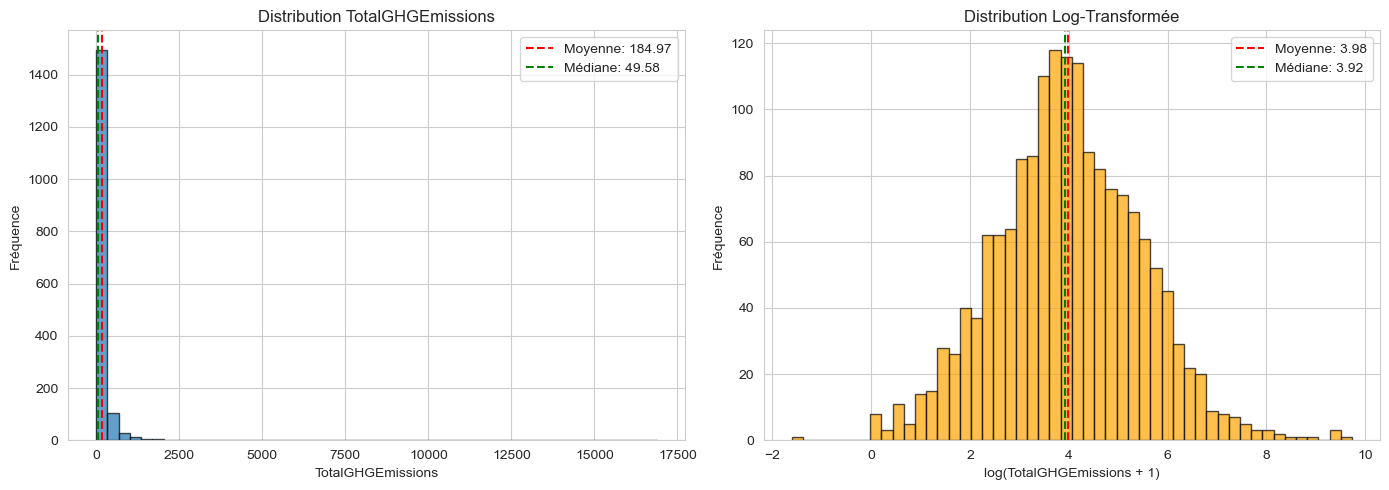


 Figure sauvegardée : ..\reports\figures\distribution_co2.png


In [9]:
# Visualisation distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution brute
axes[0].hist(target_data, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(target_data.mean(), color='red', linestyle='--', label=f'Moyenne: {target_data.mean():.2f}')
axes[0].axvline(target_data.median(), color='green', linestyle='--', label=f'Médiane: {target_data.median():.2f}')
axes[0].set_xlabel('TotalGHGEmissions')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution TotalGHGEmissions')
axes[0].legend()

# Distribution log
log_target = np.log1p(target_data)
axes[1].hist(log_target, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(log_target.mean(), color='red', linestyle='--', label=f'Moyenne: {log_target.mean():.2f}')
axes[1].axvline(log_target.median(), color='green', linestyle='--', label=f'Médiane: {log_target.median():.2f}')
axes[1].set_xlabel('log(TotalGHGEmissions + 1)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution Log-Transformée')
axes[1].legend()

plt.tight_layout()
plt.savefig(figures/'distribution_co2.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardée : {figures/'distribution_co2.png'}")

### Insight 3.2
> La première distribution de la variable montre une forte asymétrie positive avec des batiments ayant des émissions très élevées donc qui sont des ouliers. De même, elle présente un écart important entre la moyenne (184,97) et la médiane (49,58).
La seconde distribution au contraire est celle du logarithme de la variable cible, est beaucoup plus symétrique avec des pics mieux centrés (moyenne de 3.98 et médiane de 3.92) et surtout une forte réduction de l'effet des outliers détectés dans la première distribution.

> Ce qu'on retient comme recommandation tirée de cet insight, c'est que l'utilisation de la **cible log-transformée** améliorerait les performances de nos modèles de régressions.

## Section 4 : Exploration des données par type de variables

### 4.1 Variables Autorisées (Modèle 1 - Prédictif Pur)

Il s'agit de variables ayant des caractéristiques structurelles disponibles au moment du permis de construire.
Ces variables n'impliquent AUCUN data leakage car connues AVANT la cible.

In [10]:
# Certaines variables se répètent en mode, var et varGFA
# On conserve uniquement les variables sans le suffixe GFA pour éviter la redondance

variables_autorisees_clean = [
    'BuildingType', 'PrimaryPropertyType', 'City', 'State', 'ZipCode',
    'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
    'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
    'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
    'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType'
]

print(f"Variables autorisées (sans GFA) : {len(variables_autorisees_clean)}")
print(variables_autorisees_clean)


Variables autorisées (sans GFA) : 19
['BuildingType', 'PrimaryPropertyType', 'City', 'State', 'ZipCode', 'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']


 Variables catégorielles : 9
 BuildingType
  Modalités uniques : 4
BuildingType
NonResidential        1461
SPS-District K-12       98
Nonresidential COS      85
Campus                  24


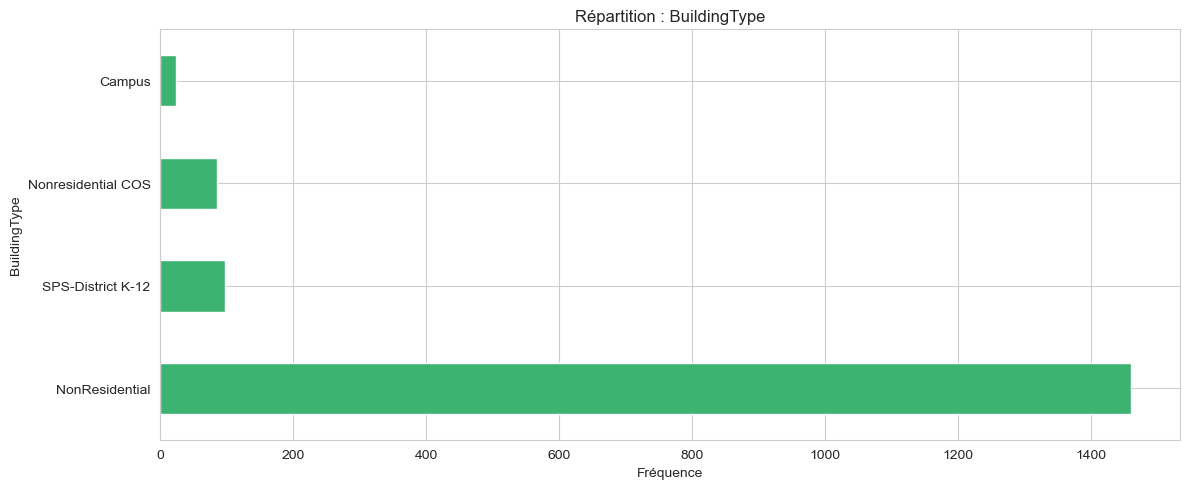

 PrimaryPropertyType
  Modalités uniques : 22
  (Trop de modalités : 22, pas de visualisation)
 City
  Modalités uniques : 1
City
Seattle    1668


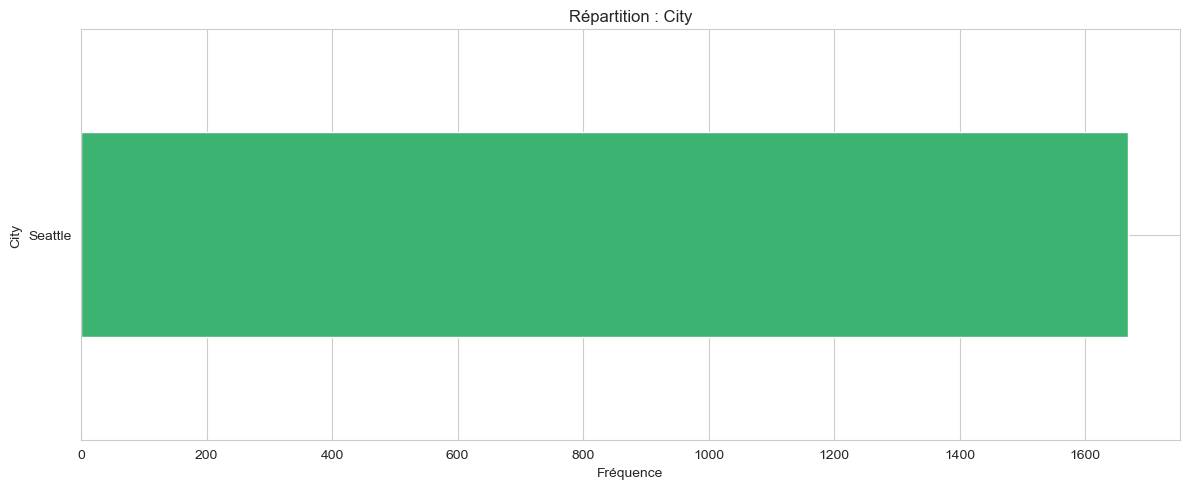

 State
  Modalités uniques : 1
State
WA    1668


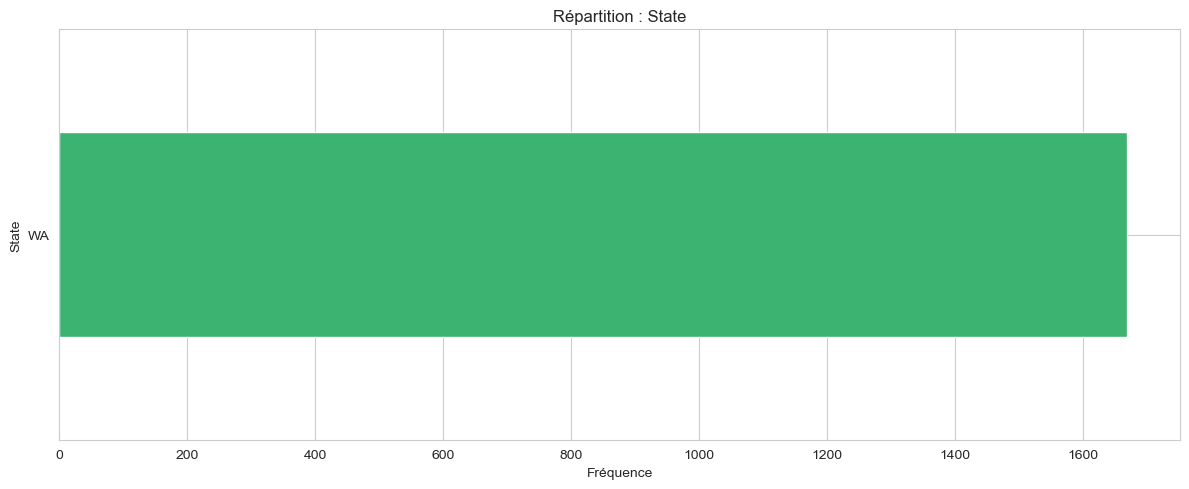

 Neighborhood
  Modalités uniques : 19
Neighborhood
DOWNTOWN                  361
GREATER DUWAMISH          346
MAGNOLIA / QUEEN ANNE     151
LAKE UNION                148
NORTHEAST                 128
EAST                      121
NORTHWEST                  81
BALLARD                    64
NORTH                      58
CENTRAL                    51
SOUTHEAST                  46
DELRIDGE                   42
SOUTHWEST                  41
North                       9
Ballard                     6
Central                     5
Northwest                   5
Delridge                    4
DELRIDGE NEIGHBORHOODS      1


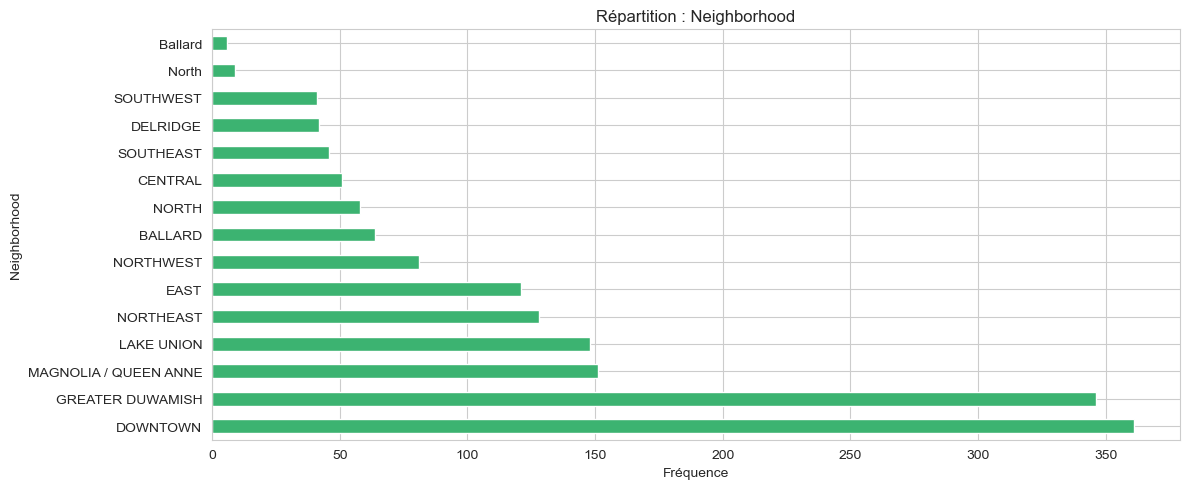

 ListOfAllPropertyUseTypes
  Modalités uniques : 373
  (Trop de modalités : 373, pas de visualisation)
 LargestPropertyUseType
  Modalités uniques : 56
  (Trop de modalités : 56, pas de visualisation)
 SecondLargestPropertyUseType
  Modalités uniques : 47
  (Trop de modalités : 47, pas de visualisation)
 ThirdLargestPropertyUseType
  Modalités uniques : 39
  (Trop de modalités : 39, pas de visualisation)


In [11]:
#  Variables catégorielles autorisées
cat_auto = df[variables_autorisees_clean].select_dtypes(include=['object']).columns.tolist()
print(f" Variables catégorielles : {len(cat_auto)}")

for col in cat_auto:
    print(f" {col}")
    n_unique = df[col].nunique()
    print(f"  Modalités uniques : {n_unique}")
    
    if n_unique <= 20:
        value_counts = df[col].value_counts()
        print(value_counts.to_string())
        
        # Visualisation
        plt.figure(figsize=(12, 5))
        value_counts.head(15).plot(kind='barh', color='mediumseagreen')
        plt.title(f'Répartition : {col}')
        plt.xlabel('Fréquence')
        plt.tight_layout()
        plt.savefig(figures / f'auto_{col}_distribution.png', dpi=100)
        plt.show()
    else:
        print(f"  (Trop de modalités : {n_unique}, pas de visualisation)")


 Variables numériques : 10
 STATISTIQUES DESCRIPTIVES (Variables Numériques Autorisées)
              Variable      Min       Q1  Médiane   Moyenne        Q3        Max       Std  Skew
               ZipCode 98006.00 98105.00 98109.00  98116.82  98125.00   98199.00     18.43  1.31
   CouncilDistrictCode     1.00     2.00     4.00      4.36      7.00       7.00      2.19  0.01
              Latitude    47.50    47.59    47.61     47.62     47.65      47.73      0.05  0.23
             Longitude  -122.41  -122.34  -122.33   -122.33   -122.32    -122.26      0.02 -0.08
             YearBuilt  1900.00  1930.00  1965.00   1961.91   1989.00    2015.00     32.74 -0.29
     NumberofBuildings     0.00     1.00     1.00      1.17      1.00     111.00      2.93 32.48
        NumberofFloors     0.00     1.00     2.00      4.12      4.00      99.00      6.56  6.04
      PropertyGFATotal 11285.00 29477.75 49289.50 118842.72 105325.00 9320156.00 297362.21 19.16
    PropertyGFAParking     0.00     0.0

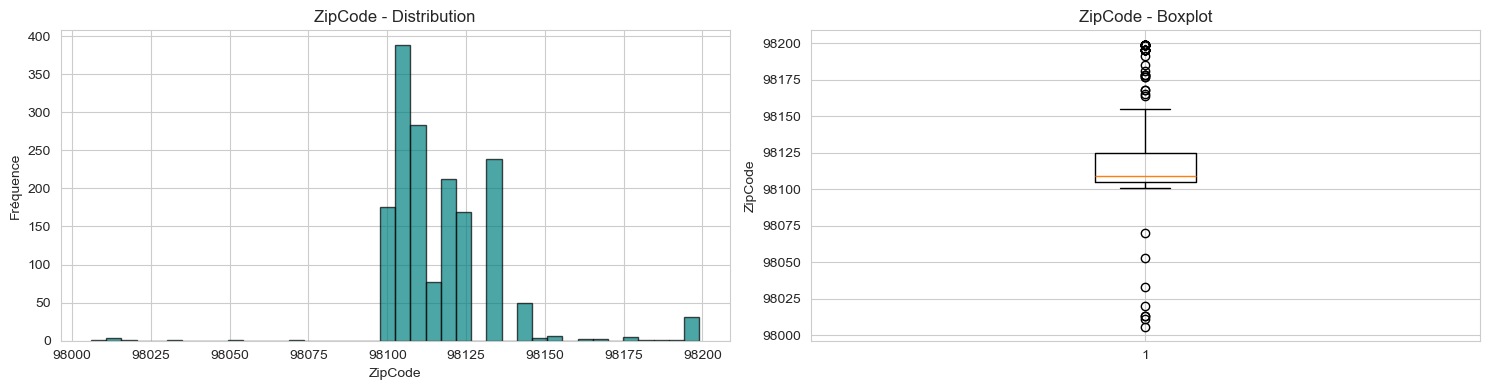

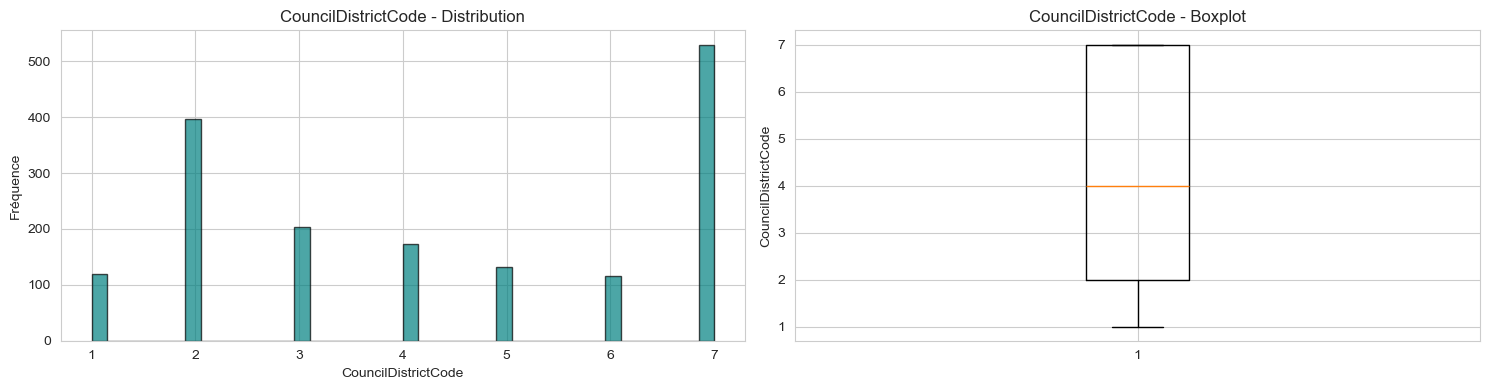

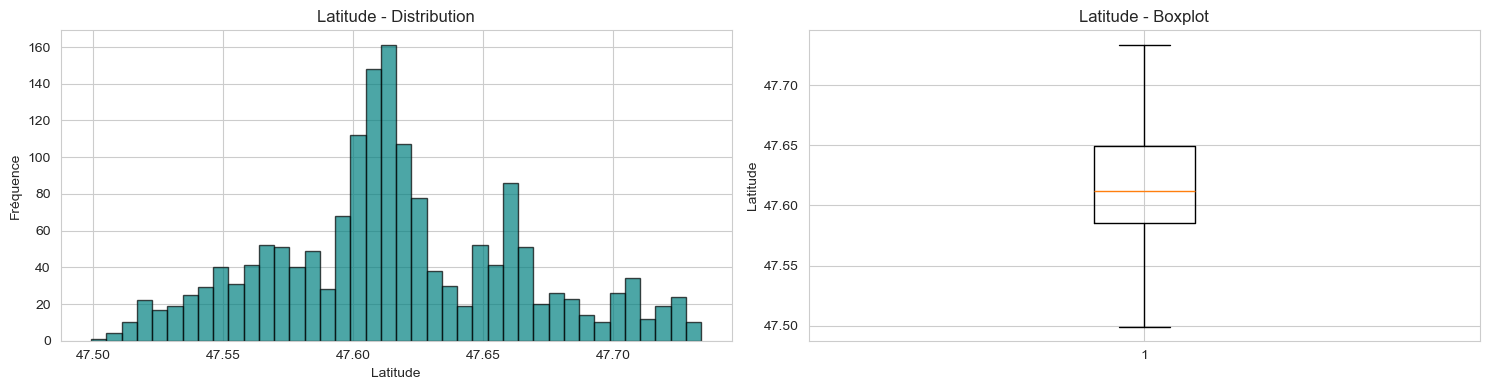

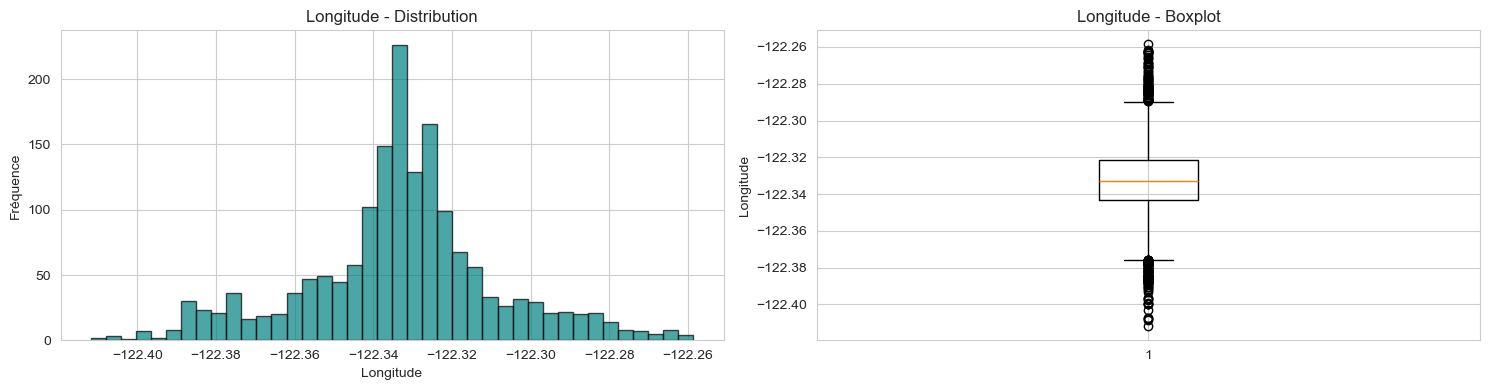

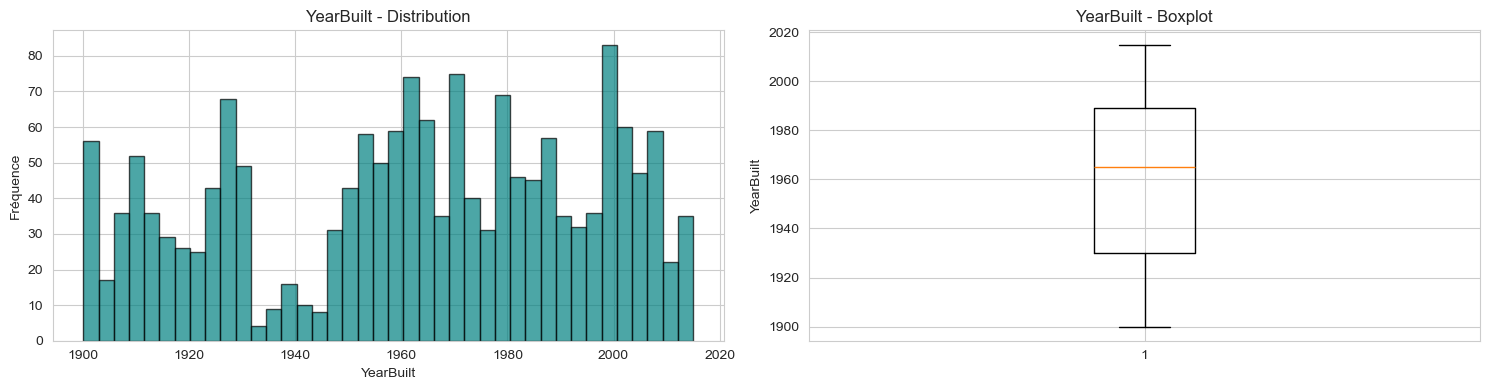

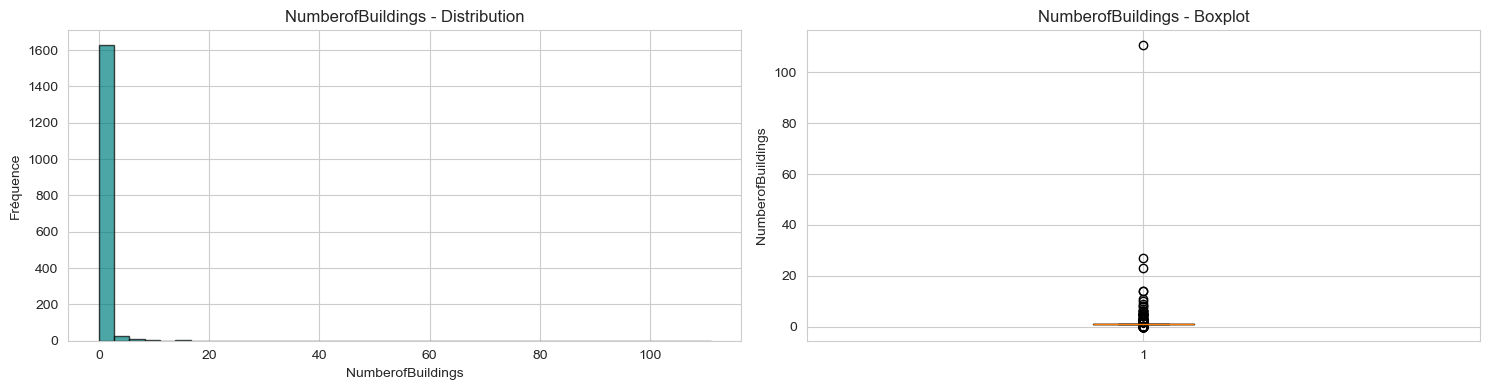

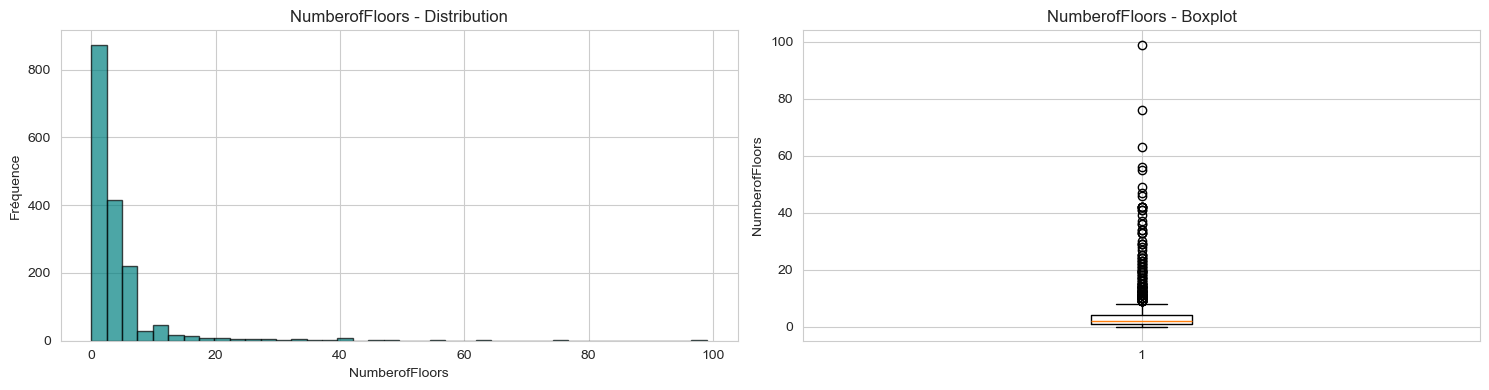

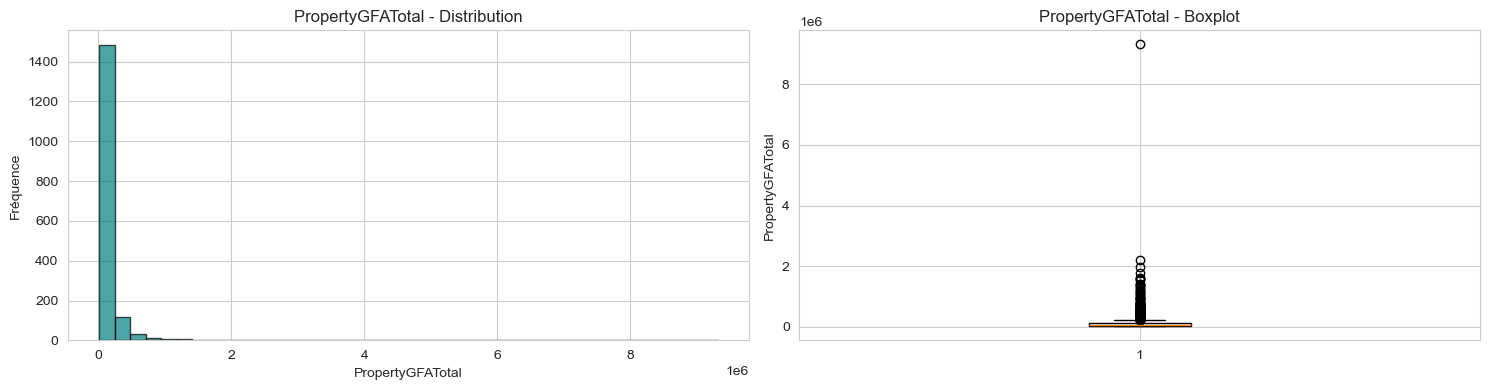

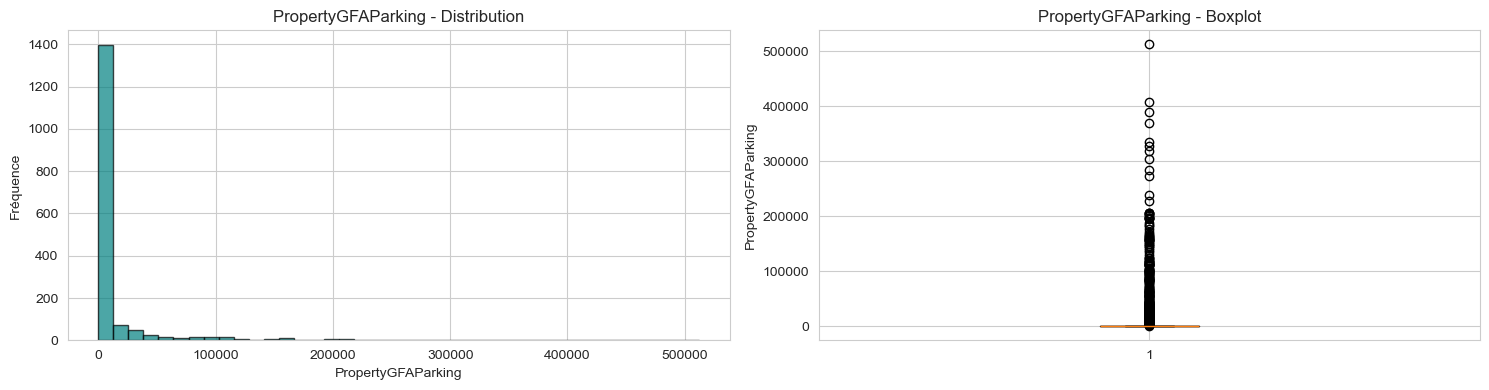

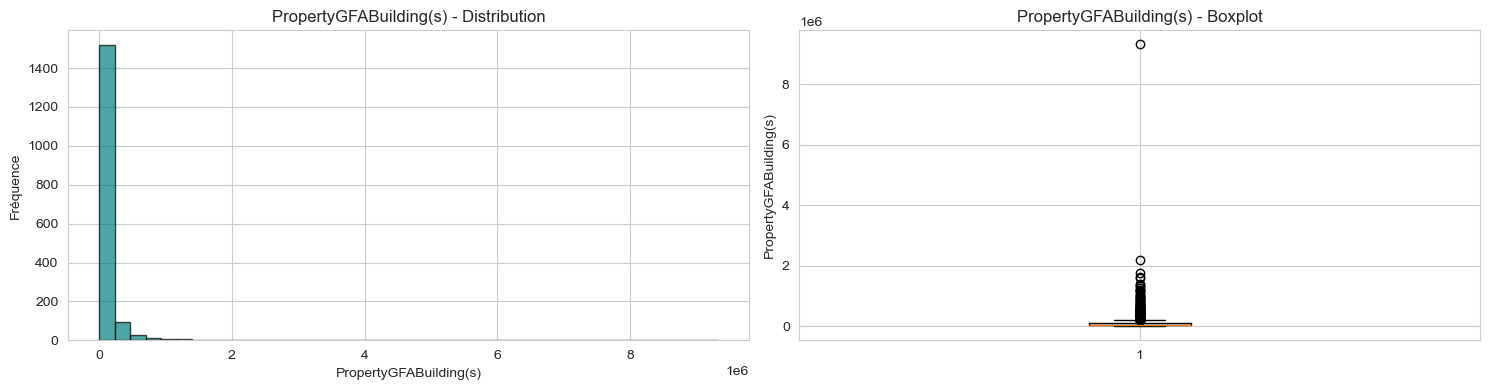

In [12]:
#  Variables numériques autorisées
num_auto = df[variables_autorisees_clean].select_dtypes(include=[np.number]).columns.tolist()
print(f" Variables numériques : {len(num_auto)}")

# Tableau stats agrégé
stats_list = []
for col in num_auto:
    stats = df[col].describe()
    stats_list.append({
        'Variable': col,
        'Min': stats['min'],
        'Q1': stats['25%'],
        'Médiane': stats['50%'],
        'Moyenne': stats['mean'],
        'Q3': stats['75%'],
        'Max': stats['max'],
        'Std': stats['std'],
        'Skew': df[col].skew()
    })

stats_df = pd.DataFrame(stats_list)
print(" STATISTIQUES DESCRIPTIVES (Variables Numériques Autorisées)")
print(stats_df.to_string(index=False, float_format='%.2f'))

# Distribution pour chaque numérique
for col in num_auto:
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # Histogramme
    axes[0].hist(df[col].dropna(), bins=40, edgecolor='black', color='teal', alpha=0.7)
    axes[0].set_title(f'{col} - Distribution')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Fréquence')
    
    # Boxplot
    axes[1].boxplot(df[col].dropna(), vert=True)
    axes[1].set_title(f'{col} - Boxplot')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    plt.savefig(figures / f'auto_{col}_distribution.png', dpi=100)
    plt.show()

                    Variable  Manquantes  Pourcentage
 ThirdLargestPropertyUseType        1315    78.836930
SecondLargestPropertyUseType         813    48.741007
                     ZipCode          16     0.959233
      LargestPropertyUseType           6     0.359712
           NumberofBuildings           2     0.119904
   ListOfAllPropertyUseTypes           2     0.119904


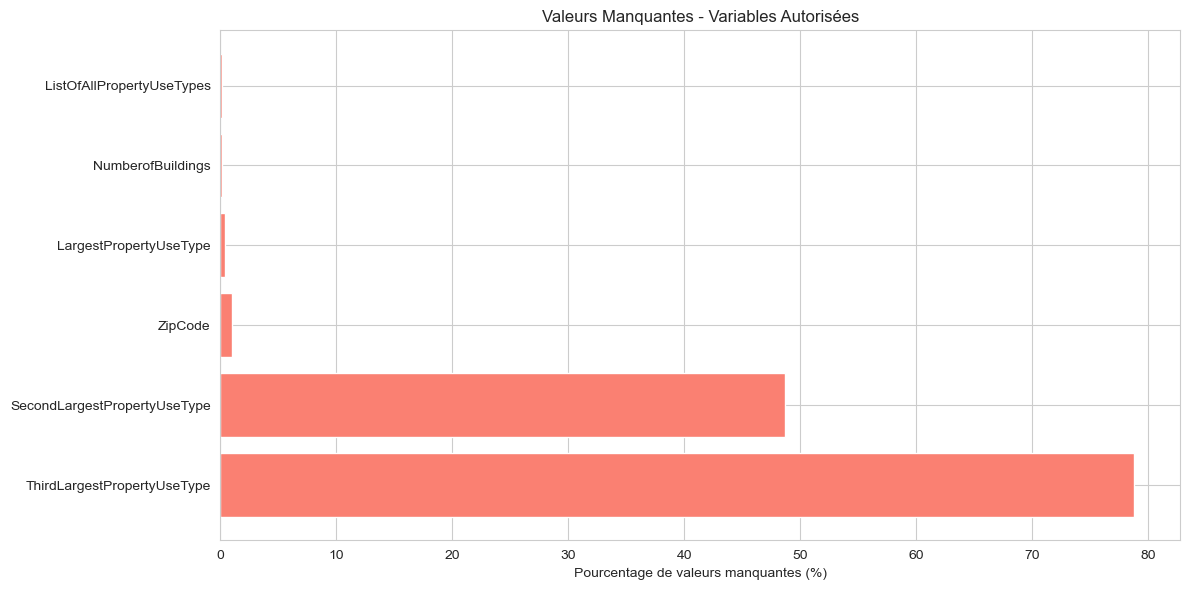

In [16]:
# Valeurs manquantes tout le monde
missing_auto = df[variables_autorisees_clean].isnull().sum()
missing_auto_pct = (missing_auto / len(df)) * 100
missing_auto_df = pd.DataFrame({
    'Variable': missing_auto.index,
    'Manquantes': missing_auto.values,
    'Pourcentage': missing_auto_pct.values
}).sort_values('Pourcentage', ascending=False)
print(missing_auto_df[missing_auto_df['Manquantes'] > 0].to_string(index=False))

# Visualisation
if len(missing_auto_df[missing_auto_df['Manquantes'] > 0]) > 0:
    plt.figure(figsize=(12, 6))
    missing_plot = missing_auto_df[missing_auto_df['Manquantes'] > 0]
    plt.barh(missing_plot['Variable'], missing_plot['Pourcentage'], color='salmon')
    plt.xlabel('Pourcentage de valeurs manquantes (%)')
    plt.title('Valeurs Manquantes - Variables Autorisées')
    plt.tight_layout()
    plt.savefig(figures / 'auto_missing_values.png', dpi=150)
    plt.show()


#### Stratégie de traitement des variables autorisées

| Colonne | Taux de NaNs | Description | Décision & Recommandation |
| --- | --- | --- | --- |
| **ThirdLargestPropertyUseType** (et GFA) | 78.84% | Troisième usage du bâtiment. | **Suppression**. Concerne moins d'un bâtiment sur cinq ; risque de sur-apprentissage. |
| **SecondLargestPropertyUseType** (et GFA) | 48.74% | Deuxième usage du bâtiment. | **Transformation binaire** : Création variable (0 = absent, 1 = présent) + suppression GFA. |
| **ZipCode** | 0.96% | Code postal. | **Imputation par mode** du Neighborhood. Si NaN persiste, mode global. |
| **LargestPropertyUseType** | 0.36% | Usage principal du bâtiment. | **Imputation par mode** du PrimaryPropertyType. |
| **NumberofBuildings** | 0.12% | Nombre de bâtiments. | **Suppression lignes** (2 obs). Impact négligeable. |
| **ListOfAllPropertyUseTypes** | 0.12% | Liste complète des usages. | **Suppression lignes** (2 obs). Impact négligeable. |

### 4.2 Variables de Consommation (Modèle 2 - Data Leakage Complet)

Ces variables mesurent la consommation réelle du batiment, elle sont alors mesurées après les émissions de CO2, c'est pourquoi on parle de Data leakage

In [18]:
print(variables_consommation)

['SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']


In [ ]:
# Variables de consommation - nettoyage (suppression des doublons)
variables_consommation_clean = [
    'SteamUse(kBtu)', 'Electricity(kWh)', 
    'NaturalGas(therms)', 
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
    'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 
    'GHGEmissionsIntensity',
    'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)'
]

print(f"Variables consommation (sans doublons) : {len(variables_consommation_clean)}")
print(variables_consommation_clean)

# Statistiques descriptives
stats_conso_list = []
for col in variables_consommation_clean:
    if col in df.columns:
        stats = df[col].describe()
        stats_conso_list.append({
            'Variable': col,
            'Min': stats['min'],
            'Q1': stats['25%'],
            'Médiane': stats['50%'],
            'Moyenne': stats['mean'],
            'Q3': stats['75%'],
            'Max': stats['max'],
            'Std': stats['std'],
            'Manquantes': df[col].isnull().sum()
        })

stats_conso_df = pd.DataFrame(stats_conso_list)
print(" STATISTIQUES DESCRIPTIVES (Variables Consommation)")
print(stats_conso_df.to_string(index=False, float_format='%.2f'))

Variables consommation (sans doublons) : 10
['SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)']

 STATISTIQUES DESCRIPTIVES (Variables Consommation)
             Variable       Min         Q1    Médiane    Moyenne         Q3          Max         Std  Manquantes
       SteamUse(kBtu)      0.00       0.00       0.00  512572.56       0.00 134943456.00  5513943.68           2
     Electricity(kWh) -33826.80  211408.32  472415.34 1712629.78 1420746.94 192577488.00  6095171.52           2
   NaturalGas(therms)      0.00       0.00    4982.63   19708.45   15200.00   2979090.00    93708.14           2
     SiteEUI(kBtu/sf)      0.00      33.70      51.90      72.16      81.70       834.40       74.05           3
   SiteEUIWN(kBtu/sf)      0.00      35.40      53.90      74.57      85.20       834.40       75.03           3
   

In [22]:
# Corrélation avec cible
print("\n📊 CORRÉLATION AVEC TotalGHGEmissions")
corr_conso = df[variables_consommation_clean + ['TotalGHGEmissions']].corr()['TotalGHGEmissions'].sort_values(ascending=False)
print(corr_conso.drop('TotalGHGEmissions').to_string())


📊 CORRÉLATION AVEC TotalGHGEmissions
SiteEnergyUse(kBtu)      0.859940
SiteEnergyUseWN(kBtu)    0.855982
NaturalGas(therms)       0.725999
Electricity(kWh)         0.686572
SteamUse(kBtu)           0.684001
GHGEmissionsIntensity    0.467224
SiteEUI(kBtu/sf)         0.257353
SiteEUIWN(kBtu/sf)       0.244926
SourceEUI(kBtu/sf)       0.203679
SourceEUIWN(kBtu/sf)     0.189798


## Section 4 : Valeurs manquantes des variables explicatives

In [25]:
# Analyse valeurs manquantes - Variables autorisées uniquement
missing = df[variables_exp_tot].isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Variable': missing.index,
    'Manquantes': missing.values,
    'Pourcentage': missing_pct.values
}).sort_values('Pourcentage', ascending=False)

missing_df = missing_df[missing_df['Manquantes'] > 0]


print(" VALEURS MANQUANTES (Variables explicatives + Cible)")

print(missing_df.to_string(index=False))

 VALEURS MANQUANTES (Variables explicatives + Cible)
                       Variable  Manquantes  Pourcentage
       YearsENERGYSTARCertified        1570    94.124700
 ThirdLargestPropertyUseTypeGFA        1315    78.836930
    ThirdLargestPropertyUseType        1315    78.836930
SecondLargestPropertyUseTypeGFA         813    48.741007
   SecondLargestPropertyUseType         813    48.741007
                ENERGYSTARScore         574    34.412470
                        ZipCode          16     0.959233
         LargestPropertyUseType           6     0.359712
      LargestPropertyUseTypeGFA           6     0.359712
             SiteEUIWN(kBtu/sf)           3     0.179856
          SiteEnergyUseWN(kBtu)           3     0.179856
               SiteEUI(kBtu/sf)           3     0.179856
                 SteamUse(kBtu)           2     0.119904
             NaturalGas(therms)           2     0.119904
               NaturalGas(kBtu)           2     0.119904
               Electricity(kWh)    

### Insights 4.1 
On voit qu'il y a une situation assez critique.
- Les variables avec des missing percentage supérieur à 70% : 'YearsENERGYSTARCertified', 'ThirdLargestPropertyUseTypeGFA'